# MNIST classification using ensemble of 5 CNNs

In [ ]:
# import libraries
import numpy as np # linear algebra, matrix multiplications
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Load data

In [ ]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

## Check shape, data type

In [ ]:
print(train.shape)
ntrain = train.shape[0]

print(test.shape)
ntest = test.shape[0]

train.head(10)

In [ ]:
# check data type
print(train.dtypes[:5]) # all int64, otherwise do train = train.astype('int64')
print(train.dtypes[:5]) # all int64, otherwise do test = test.astype('int64')

## Extract xtrain, ytrain

In [ ]:
# array containing labels of each image
ytrain = train["label"]
print("Shape of ytrain: ", ytrain.shape)

# dataframe containing all pixels (the label column is dropped)
xtrain = train.drop("label", axis=1)

# the images are in square form, so dim*dim = 784
from math import sqrt
dim = int(sqrt(xtrain.shape[1]))
print("The images are {}x{} squares.".format(dim, dim))

print("Shape of xtrain: ", xtrain.shape)

In [ ]:
ytrain.head(5)

## Mean and std of the classes

In [ ]:
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

# plot how many images there are in each class
sns.countplot(ytrain)

print(ytrain.shape)
print(type(ytrain))

# array with each class and its number of images
vals_class = ytrain.value_counts()
print(vals_class)

# mean and std
cls_mean = np.mean(vals_class)
cls_std = np.std(vals_class,ddof=1)

print("The mean amount of elements per class is", cls_mean)
print("The standard deviation in the element per class distribution is", cls_std)

# 68% - 95% - 99% rule, the 68% of the data should be cls_std away from the mean and so on
# https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
if cls_std > cls_mean * (0.6827 / 2):
    print("The standard deviation is high")
    
# if the data is skewed then we won't be able to use accurace as its results will be misleading and we may use F-beta score instead.

## 2.6. Check null and missing values

In [ ]:
def check_nan(df):
    print(df.isnull().any().describe())
    print("There are missing values" if df.isnull().any().any() else "There are no missing values")

    if df.isnull().any().any():
        print(df.isnull().sum(axis=0))
        
    print()
        
check_nan(xtrain)
check_nan(test)

## Visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# convert train dataset to (num_images, img_rows, img_cols) format in order to plot it
xtrain_vis = xtrain.values.reshape(ntrain, dim, dim)

# subplot(2,3,3) = subplot(233)
# a grid of 3x3 is created, then plots are inserted in some of these slots
for i in range(0,9): # how many imgs will show from the 3x3 grid
    plt.subplot(330 + (i+1)) # open next subplot
    plt.imshow(xtrain_vis[i], cmap=plt.get_cmap('gray'))
    plt.title(ytrain[i]);

## Normalization

In [ ]:
# Normalize the data
xtrain = xtrain / 255.0
test = test / 255.0

## Reshape

In [ ]:
# reshape of image data to (nimg, img_rows, img_cols, 1)
def df_reshape(df):
    print("Previous shape, pixels are in 1D vector:", df.shape)
    df = df.values.reshape(-1, dim, dim, 1) 
    # -1 means the dimension doesn't change, so 42000 in the case of xtrain and 28000 in the case of test
    print("After reshape, pixels are a 28x28x1 3D matrix:", df.shape)
    return df

xtrain = df_reshape(xtrain) # numpy.ndarray type
test = df_reshape(test) # numpy.ndarray type

## One hot encoding of label

In [ ]:
from keras.utils.np_utils import to_categorical

print(type(ytrain))
# number of classes, in this case 10
nclasses = ytrain.max() - ytrain.min() + 1

print("Shape of ytrain before: ", ytrain.shape) # (42000,)

ytrain = to_categorical(ytrain, num_classes = nclasses)

print("Shape of ytrain after: ", ytrain.shape) # (42000, 10), also numpy.ndarray type
print(type(ytrain))

## Split training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
seed = 2
np.random.seed(seed)

# percentage of xtrain which will be xval
split_pct = 0.1

# Split the train and the validation set
xtrain, xval, ytrain, yval = train_test_split(xtrain,
                                              ytrain, 
                                              test_size=split_pct,
                                              random_state=seed,
                                              shuffle=True,
                                              stratify=ytrain
                                             )

print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

## CNN

In [ ]:
from keras import backend as K

# for the architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D

# optimizer, data generator and learning rate reductor
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

In [ ]:
nets = 5
model = [0] *nets
for i in range(nets):

    model[i] = Sequential()

    model[i].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Flatten())
    model[i].add(Dropout(0.4))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=10,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(xtrain)

## Fit the model

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# train the network
history = [0] * nets
epochs = 45
for j in range(nets):
    print("CNN ",j+1)
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(xtrain, ytrain, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=1)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

## Plot loss and accuracy

Loss and accuracy graph of one of the 5 CNN models

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history[4].history['loss'], color='b', label="Training loss")
ax[0].plot(history[4].history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history[4].history['acc'], color='b', label="Training accuracy")
ax[1].plot(history[4].history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

## **Ensemble Predictions and submit**

In [ ]:
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("predictions.csv",index=False)

## Score 0.99742!!
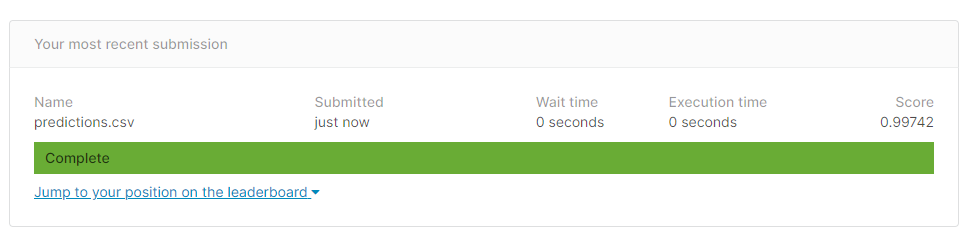

## Credits
The code here was inspired by the following outstanding Kaggle kernels
* [Chris Deotte - 25 Million Images! [0.99757] MNIST](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist/notebook)
* [Ane - MNIST with CNN in Keras - Detailed explanation](https://www.kaggle.com/anebzt/mnist-with-cnn-in-keras-detailed-explanation)